## Analyze A/B Test Results


## Table of Contents
- [Introduction](#intro)
- [Part I - Probability](#probability)
- [Part II - A/B Test](#ab_test)
- [Part III - Regression](#regression)


<a id='intro'></a>
### Introduction

A/B tests are very commonly performed by data analysts and data scientists.  It is important that you get some practice working with the difficulties of these 

For this project, you will be working to understand the results of an A/B test run by an e-commerce website.  Your goal is to work through this notebook to help the company understand if they should implement the new page, keep the old page, or perhaps run the experiment longer to make their decision.

**As you work through this notebook, follow along in the classroom and answer the corresponding quiz questions associated with each question.** The labels for each classroom concept are provided for each question.  This will assure you are on the right track as you work through the project, and you can feel more confident in your final submission meeting the criteria.  As a final check, assure you meet all the criteria on the [RUBRIC](https://review.udacity.com/#!/projects/37e27304-ad47-4eb0-a1ab-8c12f60e43d0/rubric).

<a id='probability'></a>
#### Part I - Probability

To get started, let's import our libraries.

In [7]:
import pandas as pd
import numpy as np
import random
import matplotlib.pyplot as plt
%matplotlib inline
#We are setting the seed to assure you get the same answers on quizzes as we set up
random.seed(42)

`1.` Now, read in the `ab_data.csv` data. Store it in `df`.  **Use your dataframe to answer the questions in Quiz 1 of the classroom.**

a. Read in the dataset and take a look at the top few rows here:

In [8]:
# reading in the dataset and looking at the top few rows
df = pd.read_csv('ab_data.csv')
df.head()

user_id                   timestamp      group landing_page  converted
0   851104  2017-01-21 22:11:48.556739    control     old_page          0
1   804228  2017-01-12 08:01:45.159739    control     old_page          0
2   661590  2017-01-11 16:55:06.154213  treatment     new_page          0
3   853541  2017-01-08 18:28:03.143765  treatment     new_page          0
4   864975  2017-01-21 01:52:26.210827    control     old_page          1

b. Use the below cell to find the number of rows in the dataset.

In [9]:
#finding the number of rows of our dataset
df.shape[0]

294478

c. The number of unique users in the dataset.

In [10]:
# finding the number of unique users in the dataset
df.user_id.nunique()

290584

d. The proportion of users converted.

In [11]:
# finding the mean of users who converted from a page to the other
df.converted.mean()

0.11965919355605512

e. The number of times the `new_page` and `treatment` don't line up.

In [12]:
# finding the number of rows in which the landing_page and group are equal to new_page and control, respectively
new_control = df.query('landing_page == "new_page" and group == "control"').group.count()

#finding the number of rows in which the landing_page and group are equal to old_page and treatment, respectively
old_treatment = df.query('landing_page == "old_page" and group == "treatment"').group.count()

#finding the sum of both the above values for non-matching values
dont_match = new_control + old_treatment
dont_match

3893

f. Do any of the rows have missing values?

In [13]:
#finding general information about the data and if there are missing values
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 294478 entries, 0 to 294477
Data columns (total 5 columns):
 #   Column        Non-Null Count   Dtype 
---  ------        --------------   ----- 
 0   user_id       294478 non-null  int64 
 1   timestamp     294478 non-null  object
 2   group         294478 non-null  object
 3   landing_page  294478 non-null  object
 4   converted     294478 non-null  int64 
dtypes: int64(2), object(3)
memory usage: 11.2+ MB


`2.` For the rows where **treatment** is not aligned with **new_page** or **control** is not aligned with **old_page**, we cannot be sure if this row truly received the new or old page.  Use **Quiz 2** in the classroom to provide how we should handle these rows.  

a. Now use the answer to the quiz to create a new dataset that meets the specifications from the quiz.  Store your new dataframe in **df2**.

In [14]:
#creating a new dataframe with rows where group is control and landing page is old page
old = df.query('group == "control" and landing_page == "old_page"')

#creating a new dataframe with rows where group is treatment and landing page is new page
new = df.query('group == "treatment" and landing_page == "new_page"')

#concatenating the two dataframes created above to create one uniform dataframe
df2 = pd.concat([old, new])

In [15]:
# Double Check all of the correct rows were removed - this should be 0
df2[((df2['group'] == 'treatment') == (df2['landing_page'] == 'new_page')) == False].shape[0]

0

`3.` Use **df2** and the cells below to answer questions for **Quiz3** in the classroom.

a. How many unique **user_id**s are in **df2**?

In [16]:
#finding the number of unique user IDs in the new dataframe
df2.user_id.nunique()

290584

b. There is one **user_id** repeated in **df2**.  What is it?

In [17]:
#finding the duplicated row in the new dataframe
duplicated_row = df2[df2.duplicated(['user_id'], keep=False)]
duplicated_row

user_id                   timestamp      group landing_page  converted
1899   773192  2017-01-09 05:37:58.781806  treatment     new_page          0
2893   773192  2017-01-14 02:55:59.590927  treatment     new_page          0

c. What is the row information for the repeat **user_id**? 

In [18]:
#finding general information of the duplicated row
duplicated_row.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2 entries, 1899 to 2893
Data columns (total 5 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   user_id       2 non-null      int64 
 1   timestamp     2 non-null      object
 2   group         2 non-null      object
 3   landing_page  2 non-null      object
 4   converted     2 non-null      int64 
dtypes: int64(2), object(3)
memory usage: 96.0+ bytes


d. Remove **one** of the rows with a duplicate **user_id**, but keep your dataframe as **df2**.

In [19]:
#dropping the duplicate row from the new dataframe
df2 = df2.drop_duplicates('user_id');

`4.` Use **df2** in the below cells to answer the quiz questions related to **Quiz 4** in the classroom.

a. What is the probability of an individual converting regardless of the page they receive?

In [20]:
#finding the mean of converted users 
df2.converted.mean()

0.11959708724499628

b. Given that an individual was in the `control` group, what is the probability they converted?

In [21]:
#finding the mean of the converted control group  
df2.query('group == "control"').converted.mean()

0.1203863045004612

c. Given that an individual was in the `treatment` group, what is the probability they converted?

In [22]:
#finding the mean of the converted treatment group 
df2.query('group == "treatment"').converted.mean()

0.11880806551510564

d. What is the probability that an individual received the new page?

In [23]:
#finding the probability of receiving the new page 
df2.query('landing_page == "new_page"').landing_page.count()/df2.shape[0]

0.5000619442226688

e. Consider your results from a. through d. above, and explain below whether you think there is sufficient evidence to say that the new treatment page leads to more conversions.

**From the previous calculations, it is evident that the rates of converted users from the control group is around 12% and conversely the rate of converted users from the treatment group nearly 12% as well. As for the probability of landing page, 50% of the users are using the new page which means the other 50% of users are using the old page. so far there is no evidence that the new treatment page leads to more conversions.**

<a id='ab_test'></a>
### Part II - A/B Test

Notice that because of the time stamp associated with each event, you could technically run a hypothesis test continuously as each observation was observed.  

However, then the hard question is do you stop as soon as one page is considered significantly better than another or does it need to happen consistently for a certain amount of time?  How long do you run to render a decision that neither page is better than another?  

These questions are the difficult parts associated with A/B tests in general.  


`1.` For now, consider you need to make the decision just based on all the data provided.  If you want to assume that the old page is better unless the new page proves to be definitely better at a Type I error rate of 5%, what should your null and alternative hypotheses be?  You can state your hypothesis in terms of words or in terms of **$p_{old}$** and **$p_{new}$**, which are the converted rates for the old and new pages.

H0: $p_{old}$ >= $p_{new}$

H1: $p_{old}$ < $p_{new}$

`2.` Assume under the null hypothesis, $p_{new}$ and $p_{old}$ both have "true" success rates equal to the **converted** success rate regardless of page - that is $p_{new}$ and $p_{old}$ are equal. Furthermore, assume they are equal to the **converted** rate in **ab_data.csv** regardless of the page. <br><br>

Use a sample size for each page equal to the ones in **ab_data.csv**.  <br><br>

Perform the sampling distribution for the difference in **converted** between the two pages over 10,000 iterations of calculating an estimate from the null.  <br><br>

Use the cells below to provide the necessary parts of this simulation.  If this doesn't make complete sense right now, don't worry - you are going to work through the problems below to complete this problem.  You can use **Quiz 5** in the classroom to make sure you are on the right track.<br><br>

a. What is the **convert rate** for $p_{new}$ under the null? 

In [24]:
#finding the convert rate for the new page under the null
p_new = df2['converted'].mean()
p_new

0.11959708724499628

b. What is the **convert rate** for $p_{old}$ under the null? <br><br>

In [25]:
#finding the convert rate for the old page under the null
p_old = df2['converted'].mean()
p_old

0.11959708724499628

c. What is $n_{new}$?

In [26]:
#finding the number of users in the treatment group
n_new = df2.query('group == "treatment"').group.count()
n_new

145310

d. What is $n_{old}$?

In [58]:
#finding the number of users in the control group
n_old = df2.query('group == "control"').group.count()
n_old

145274

e. Simulate $n_{new}$ transactions with a convert rate of $p_{new}$ under the null.  Store these $n_{new}$ 1's and 0's in **new_page_converted**.

In [59]:
#simulating transactions with convert rate of p(new) under the null
new_page_converted = np.random.choice([0,1], size=n_new, p=[p_new, 1-p_new])
new_page_converted

array([1, 1, 1, ..., 1, 1, 1])

f. Simulate $n_{old}$ transactions with a convert rate of $p_{old}$ under the null.  Store these $n_{old}$ 1's and 0's in **old_page_converted**.

In [60]:
#simulating transactions with convert rate of p(old) under the null
old_page_converted = np.random.choice([0,1], size=n_old, p=[p_old, 1-p_old])
old_page_converted

array([1, 1, 1, ..., 1, 1, 1])

g. Find $p_{new}$ - $p_{old}$ for your simulated values from part (e) and (f).

In [61]:
difference = new_page_converted.mean() - old_page_converted.mean()
difference

-0.0020009805945285786

h. Simulate 10,000 $p_{new}$ - $p_{old}$ values using this same process similarly to the one you calculated in parts **a. through g.** above.  Store all 10,000 values in a numpy array called **p_diffs**.

In [62]:
#creating p_diffs
p_diffs = []
#Simulating 10,000 values of the difference using bootsrapping 
for _ in range(10000):
    new_page_converted = np.random.choice([0,1], size=n_new, p=[1-p_new, p_new])
    old_page_converted = np.random.choice([0,1], size=n_old, p=[1-p_old, p_old])
    difference = new_page_converted.mean() - old_page_converted.mean()
    p_diffs.append(difference)
# converting p_diffs to numpy array format
p_diffs = np.array(p_diffs)    

i. Plot a histogram of the **p_diffs**.  Does this plot look like what you expected?  Use the matching problem in the classroom to assure you fully understand what was computed here.

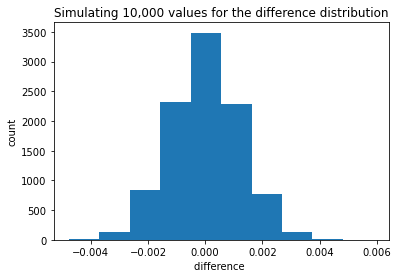

In [56]:
#plotting a histogram of the difference distribution 
plt.hist(p_diffs);
plt.xlabel('difference ')
plt.ylabel('count')
plt.title('Simulating 10,000 values for the difference distribution');

j. What proportion of the **p_diffs** are greater than the actual difference observed in **ab_data.csv**?

In [57]:
#finding the actual difference of the converts between the new and old pages
actual_diff = df2.query('landing_page == "new_page"').converted.mean() - df2.query('landing_page == "old_page"').converted.mean()
actual_diff

-0.0015782389853555567

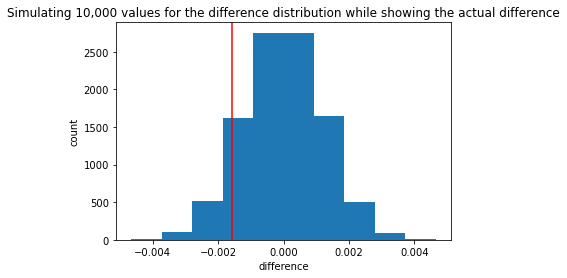

In [54]:
#showing the actual diffrence on the previous histogram
plt.hist(p_diffs);
plt.axvline(x=actual_diff, color='red');
plt.xlabel('difference')
plt.ylabel('count')
plt.title('Simulating 10,000 values for the difference distribution while showing the actual difference');

In [65]:
#finding the p-value
(p_diffs > actual_diff).mean()

0.9035

k. In words, explain what you just computed in part **j.**  What is this value called in scientific studies?  What does this value mean in terms of whether or not there is a difference between the new and old pages?

**The actual difference calculated in part j represents the actual difference between the original dataset's new and old page conversion rates, while the p_diffs calculated in parts h represents the simulated dataframe's new and old pages conversion rates. The p-value is then calculated using the two values which turned out to be %90.35 and it represents the confidence of the hypothesis, and in this case the p-value is considerably very large which in my opinion shows weak evidence, which indicates a failure to reject the null hypothesis.**

l. We could also use a built-in to achieve similar results.  Though using the built-in might be easier to code, the above portions are a walkthrough of the ideas that are critical to correctly thinking about statistical significance. Fill in the below to calculate the number of conversions for each page, as well as the number of individuals who received each page. Let `n_old` and `n_new` refer the the number of rows associated with the old page and new pages, respectively.

In [67]:
import statsmodels.api as sm

convert_old = sum(df2.query('landing_page == "old_page"').converted)
convert_new = sum(df2.query('landing_page == "new_page"').converted)
n_old = df2.query('landing_page == "old_page"').group.count()
n_new = df2.query('landing_page == "new_page"').group.count()

m. Now use `stats.proportions_ztest` to compute your test statistic and p-value.  [Here](http://knowledgetack.com/python/statsmodels/proportions_ztest/) is a helpful link on using the built in.

In [74]:
#finding the z-score and p-value using the stats library directly rather than calculating them
z_score, p_value = sm.stats.proportions_ztest([convert_old, convert_new], [n_old, n_new], alternative='smaller')
z_score, p_value

(1.3109241984234394, 0.9050583127590245)

n. What do the z-score and p-value you computed in the previous question mean for the conversion rates of the old and new pages?  Do they agree with the findings in parts **j.** and **k.**?

**The z-score is 1.31 which is less than 1.65, and the p-value is %90.50 which is less than 95%, which provides weak evidence of the alternative hypothesis to be proven which indicated a failure to reject the null hypothesis. And yes, they do agree with the findings in j and k.**

<a id='regression'></a>
### Part III - A regression approach

`1.` In this final part, you will see that the result you acheived in the previous A/B test can also be acheived by performing regression.<br><br>

a. Since each row is either a conversion or no conversion, what type of regression should you be performing in this case?

**Logistic regression.**

b. The goal is to use **statsmodels** to fit the regression model you specified in part **a.** to see if there is a significant difference in conversion based on which page a customer receives.  However, you first need to create a column for the intercept, and create a dummy variable column for which page each user received.  Add an **intercept** column, as well as an **ab_page** column, which is 1 when an individual receives the **treatment** and 0 if **control**.

In [79]:
#creating dummy variable and intercept columns
df2['intercept'] = 1
df2[['control','ab_page']] = pd.get_dummies(df2['group'])
#projecting the updated dataset with added columns
df2.head(10)

user_id                   timestamp    group landing_page  converted  \
0    851104  2017-01-21 22:11:48.556739  control     old_page          0   
1    804228  2017-01-12 08:01:45.159739  control     old_page          0   
4    864975  2017-01-21 01:52:26.210827  control     old_page          1   
5    936923  2017-01-10 15:20:49.083499  control     old_page          0   
7    719014  2017-01-17 01:48:29.539573  control     old_page          0   
15   644214  2017-01-22 02:05:21.719434  control     old_page          1   
16   847721  2017-01-17 14:01:00.090575  control     old_page          0   
18   650559  2017-01-24 11:55:51.084801  control     old_page          0   
19   935734  2017-01-17 20:33:37.428378  control     old_page          0   
25   746742  2017-01-23 11:38:29.592148  control     old_page          0   

    intercept  control  ab_page  
0           1        1        0  
1           1        1        0  
4           1        1        0  
5           1        1        0  
7           1        1        0  
15          1        1        0  
16          1        1        0  
18          1        1        0  
19          1        1        0  
25          1        1        0

c. Use **statsmodels** to import your regression model.  Instantiate the model, and fit the model using the two columns you created in part **b.** to predict whether or not an individual converts.

In [81]:
#Creating a logistic regression model 
import statsmodels.api as sm
logistic_regression = sm.Logit(df2['converted'], df2[['intercept', 'ab_page']])
#Fitting the model
result = logistic_regression.fit()

Optimization terminated successfully.
         Current function value: 0.366118
         Iterations 6


d. Provide the summary of your model below, and use it as necessary to answer the following questions.

In [82]:
#Providing the model's summary
result.summary2()

<class 'statsmodels.iolib.summary2.Summary'>
"""
                          Results: Logit
==================================================================
Model:              Logit            Pseudo R-squared: 0.000      
Dependent Variable: converted        AIC:              212780.3502
Date:               2020-12-04 13:29 BIC:              212801.5095
No. Observations:   290584           Log-Likelihood:   -1.0639e+05
Df Model:           1                LL-Null:          -1.0639e+05
Df Residuals:       290582           LLR p-value:      0.18988    
Converged:          1.0000           Scale:            1.0000     
No. Iterations:     6.0000                                        
-------------------------------------------------------------------
              Coef.   Std.Err.      z      P>|z|    [0.025   0.975]
-------------------------------------------------------------------
intercept    -1.9888    0.0081  -246.6690  0.0000  -2.0046  -1.9730
ab_page      -0.0150    0.0114    -1.3109  0.1899  -0.0374   0.0074
==================================================================

"""

e. What is the p-value associated with **ab_page**? Why does it differ from the value you found in **Part II**?<br><br>  **Hint**: What are the null and alternative hypotheses associated with your regression model, and how do they compare to the null and alternative hypotheses in the **Part II**?

**The p-value of the ab_page column is %18.99 which is lower than the p-value in part II. The reason behind it is that the previous test (Part II) was a one side test and the test here became a two side test because of the addition of the intercept column.
The hypotheses associated with the regression model:**

H0: $p_{new}$−$p_{old}$= 0
 
H1: $p_{new}$−$p_{old}$≠ 0
 
**The hypotheses are different from part II since it produced a higher p-value, but both hypotheses failed to reject the null hypotheses.**

f. Now, you are considering other things that might influence whether or not an individual converts.  Discuss why it is a good idea to consider other factors to add into your regression model.  Are there any disadvantages to adding additional terms into your regression model?

**I think adding timestamp variable from the original dataset might present more comprehensive  results since it may show if users convert more during certain times of day and how the websites traffic change with time and if certain conversions should be made regarding the traffic changes. the disadvantage that may occure from adding more terms to  become a multiple regression model is that multicollinearity might occur from highly linearly related variables and that would be a problem**


g. Now along with testing if the conversion rate changes for different pages, also add an effect based on which country a user lives. You will need to read in the **countries.csv** dataset and merge together your datasets on the approporiate rows.  [Here](https://pandas.pydata.org/pandas-docs/stable/generated/pandas.DataFrame.join.html) are the docs for joining tables. 

Does it appear that country had an impact on conversion?  Don't forget to create dummy variables for these country columns - **Hint: You will need two columns for the three dummy variables.** Provide the statistical output as well as a written response to answer this question.

In [90]:
countries_df = pd.read_csv('./countries.csv')
df_new = countries_df.set_index('user_id').join(df2.set_index('user_id'), how='inner')
df_new.head()

country                   timestamp      group landing_page  \
user_id                                                               
834778       UK  2017-01-14 23:08:43.304998    control     old_page   
928468       US  2017-01-23 14:44:16.387854  treatment     new_page   
822059       UK  2017-01-16 14:04:14.719771  treatment     new_page   
711597       UK  2017-01-22 03:14:24.763511    control     old_page   
710616       UK  2017-01-16 13:14:44.000513  treatment     new_page   

         converted  intercept  control  ab_page  
user_id                                          
834778           0          1        1        0  
928468           0          1        0        1  
822059           1          1        0        1  
711597           0          1        1        0  
710616           0          1        0        1

In [92]:
#check the size of the countries dataset
countries_df.shape

(290584, 2)

In [94]:
#Check for general information for the countries dataset
countries_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 290584 entries, 0 to 290583
Data columns (total 2 columns):
 #   Column   Non-Null Count   Dtype 
---  ------   --------------   ----- 
 0   user_id  290584 non-null  int64 
 1   country  290584 non-null  object
dtypes: int64(1), object(1)
memory usage: 4.4+ MB


In [95]:
#Checking the different countries in the dataset
countries_df.country.value_counts()

US    203619
UK     72466
CA     14499
Name: country, dtype: int64

In [97]:
### Create the necessary dummy variables
df_new[['US', 'UK', 'CA']] = pd.get_dummies(df_new['country'])
df_new.head()

country                   timestamp      group landing_page  \
user_id                                                               
834778       UK  2017-01-14 23:08:43.304998    control     old_page   
928468       US  2017-01-23 14:44:16.387854  treatment     new_page   
822059       UK  2017-01-16 14:04:14.719771  treatment     new_page   
711597       UK  2017-01-22 03:14:24.763511    control     old_page   
710616       UK  2017-01-16 13:14:44.000513  treatment     new_page   

         converted  intercept  control  ab_page  US  UK  CA  
user_id                                                      
834778           0          1        1        0   0   1   0  
928468           0          1        0        1   0   0   1  
822059           1          1        0        1   0   1   0  
711597           0          1        1        0   0   1   0  
710616           0          1        0        1   0   1   0

h. Though you have now looked at the individual factors of country and page on conversion, we would now like to look at an interaction between page and country to see if there significant effects on conversion.  Create the necessary additional columns, and fit the new model.  

Provide the summary results, and your conclusions based on the results.

In [101]:
### Fit Your Linear Model And Obtain the Results
df_new['intercept'] = 1
logit = sm.Logit(df_new['converted'], df_new[['intercept', 'ab_page', 'US', 'UK']])
result = logit.fit()
result.summary()

Optimization terminated successfully.
         Current function value: 0.366113
         Iterations 6


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:              converted   No. Observations:               290584
Model:                          Logit   Df Residuals:                   290580
Method:                           MLE   Df Model:                            3
Date:                Fri, 04 Dec 2020   Pseudo R-squ.:               2.323e-05
Time:                        14:40:07   Log-Likelihood:            -1.0639e+05
converged:                       True   LL-Null:                   -1.0639e+05
Covariance Type:            nonrobust   LLR p-value:                    0.1760
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept     -1.9893      0.009   -223.763      0.000      -2.007      -1.972
ab_page       -0.0149      0.011     -1.307      0.191      -0.037       0.007
US            -0.0408      0.027     -1.516      0.130      -0.093       0.012
UK             0.0099      0.013      0.743      0.457      -0.016       0.036
==============================================================================
"""

**From the regression model results, the p-value for the countries is 0.130 for the US and 0.457 for the UK which are not in the range of p>0.95 or p<0.05, which means that the null hypotheses couldn't be rejected since there is still not enough evidence, what's worth mentioning is that the UK's p value is larger than the US's which indicates that the UK users are more likely to convert to the new page than the US users.**

<a id='conclusions'></a>
## Conclusions

After conducting this A/B test using probabilities, hypotheses testing and regression models the overall consensus is that the old page is more likely to be used that the new page and users are less likely to convert according to the different mean conversion rates calculated in this analysis. the UK users might be more likely to convert to the new page than the US users
